# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

In [1]:
### YOUR CODE HERE ###
import psycopg2
import pandas as pd
import sqlite3

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}
conn = psycopg2.connect(**pg_connection)

hr_dataset = pd.read_sql_query("select * from public.hr_dataset;", conn)
production_staff = pd.read_sql_query("select * from public.production_staff;", conn)
recruting_costs = pd.read_sql_query("select * from public.recruiting_costs;", conn)
salary_grid = pd.read_sql_query("select * from public.salary_grid;", conn)


In [2]:
###КАК ВЫВЕСТИ ТИП ДАННЫХ В СТОЛБЦАХ###
type1 = pd.read_sql_query(
    "SELECT COLUMN_NAME, data_type FROM information_schema.COLUMNS WHERE TABLE_NAME = 'hr_dataset';", conn)
type1

,column_name,data_type
0,id,integer
1,Employee Name,character varying
2,Employee Number,integer
3,marriedid,integer
4,maritalstatusid,integer
5,genderid,integer
6,empstatus_id,integer
7,deptid,integer
8,perf_scoreid,integer
9,age,integer


In [3]:
cursor = conn.cursor()
sql_str = "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"

cursor.execute(sql_str)
tables_data = [a for a in cursor.fetchall()]
conn.commit()

print("Какие таблицы содержаться в Postgres: %s" % tables_data)

Какие таблицы содержаться в Postgres: [('hr_dataset',), ('production_staff',), ('recruiting_costs',), ('salary_grid',)]


### Гипотеза №1 ###
Есть зависимость между принадлежностью к той или иной расе и размером оплаты. <br>
В данном запросе мы просим вывести среднее значение оплаты **Pay** , для этого нам пришлось превести тип *money* в *numeric*, чтобы применить AVG, а также саму расу **Race Desc**. Затем группируем по расам.


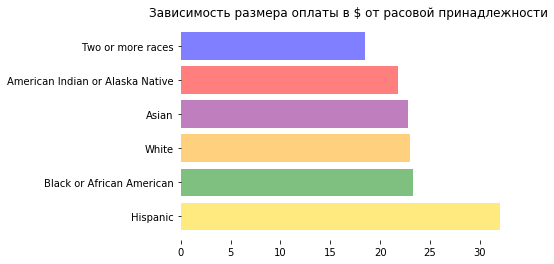

In [4]:
###Зависимость оплаты от расы###
df1 = pd.read_sql_query('''SELECT AVG(CAST("Pay" as NUMERIC)),"Race Desc" 
FROM public.production_staff 
GROUP BY "Race Desc";''', conn)
df1 = df1.drop([0]) # в первой строке было none
df1.index = df1['Race Desc']
del df1['Race Desc']
df1 = df1.sort_values('avg', ascending = False)
x = df1.values.flatten()
y = df1.index.values


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib as mpl

fig, subplot = plt.subplots()

# создаем кортеж с цветами, и затем создаем график
clr = ('gold', 'green','orange','purple','red','blue')
subplot.barh(y, x, alpha=0.5, color=clr)

# Заголовок
subplot.set_title('Зависимость размера оплаты в $ от расовой принадлежности')

#убираем рамку
plt.box(False)

plt.show()


Исходя из полученных данных, можно сделать вывод, что *латиноамериканцы* в данной компании в среднем получают больше всех. Далее, примерно на одном урове идут *афроамериканцы*, *белые* и *азиаты*. Замыкают список *индейцы или коренные жители Аляски*, а также *метисы*. Для полной картины давайте посмотрим, в каком процентном соотношении находятся расы. 

### Гипотеза №2 ###
Процентное соотношение рас не коррелируется с размером оплаты.
В данном запросе мы подсчитываем сколько имеется представителей той или иной расы, а затем считаем соотношение в процентах с помощью подзапроса.

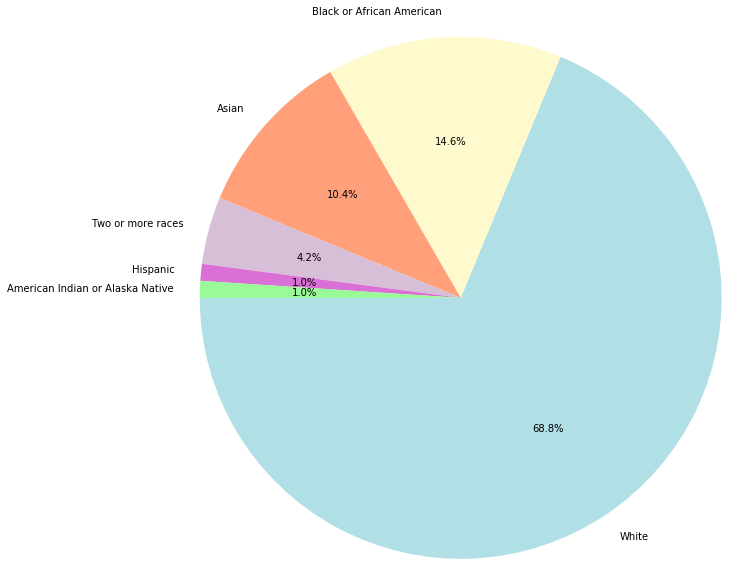

,Race Desc,count,per
0,White,140,66
1,Black or African American,31,14
2,Asian,22,10
3,Two or more races,10,4
4,Hispanic,3,1
5,American Indian or Alaska Native,3,1


In [24]:
###Ищем процентное соотношение по расам###
df2 = pd.read_sql_query('''SELECT "Race Desc", COUNT("Race Desc"), (100*COUNT("Race Desc")/
(SELECT COUNT("Race Desc") FROM public.production_staff)
) as per
FROM public.production_staff
GROUP BY "Race Desc"
ORDER BY COUNT("Race Desc") DESC;''', conn)
df2 = df2.drop([6]) # в первой строке было none


%matplotlib inline


values = df2['per']
labels = df2['Race Desc']
col = ['powderblue','lemonchiffon','lightsalmon', 'thistle', 'orchid','palegreen']

fig, subplot = plt.subplots()

subplot.pie(values, explode=None, labels = labels, startangle=180, radius=3,autopct='%.1f%%', colors = col)

plt.show()
df2


Мы убедились, что наша гипотеза была верна. 66% сотрудников являются белыми, и только по 1% составляют латиноамериканцы и афроамериканцы.  Значит первые два места в предыдущем рейтинге латиноамерикнцы и афроамериканцы заняли лишь потому, что выборка была слишком маленькая, и те 6 человек, которые работают в компании оказались на высокооплачиваемых должностях.

### Гипотеза №3 ###
Есть зависимость между возрастом и должностью. <br>
В данном запросе мы выводим средний, максимальный и минимальный возраста, перед этим переведя тип **age** в *numeric*.<br>
Группируем по должностии и сортируем по среднему возрасту.

In [26]:
###Средний, Макс, Мин возраст на каждой позиции###
df3 = pd.read_sql_query('''SELECT  AVG(CAST("age" as NUMERIC)), MAX(CAST("age" as NUMERIC)),MIN(CAST("age" as NUMERIC)), "position" 
FROM public.hr_dataset 
GROUP BY "position" 
ORDER BY AVG(CAST("age" as NUMERIC));''', conn)
df3

,avg,max,min,position
0,29.666667,33.0,28.0,Sales Manager
1,30.666667,32.0,30.0,Administrative Assistant
2,31.000000,31.0,31.0,IT Manager - Infra
3,31.666667,34.0,30.0,Accountant I
4,32.500000,38.0,28.0,BI Developer
5,33.000000,33.0,33.0,Shared Services Manager
6,34.222222,39.0,30.0,Software Engineer
7,34.333333,49.0,28.0,Network Engineer
8,34.846154,48.0,29.0,Database Administrator
9,35.000000,35.0,35.0,Director of Operations


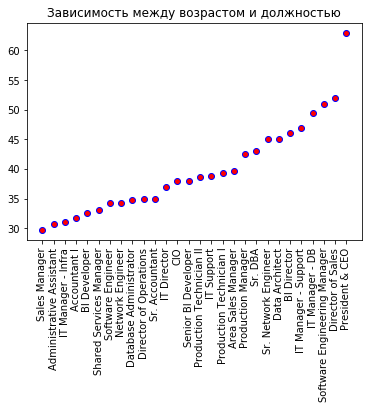

In [27]:
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

register_matplotlib_converters()

fig, subplot = plt.subplots()

x_values = df3['position'].values
y_values = df3['avg'].values
subplot.scatter(
    x=x_values, y=y_values, 
    marker='o', c='r', edgecolor='b'
)
plt.xticks(rotation='vertical')
subplot.set_title('Зависимость между возрастом и должностью')

plt.show()

Так как у нас нет списка должностей в иерархическом порядке, мы не можем дать полную оценку данному вопросу, однако, общие выводы сделать можем. Во второй половине нашего списка, отсортированного по среднему возрасту нам встречаются такие должности как *The Senior Database (Sr.DBA)*, *Senior Network Engineer*, *Business Intelligence Director(BI Director)*, *Director of Sales*. Максимальный средний возраст принадлежит генеральному директору (CEO) компании. В то же время, в первой половине списка, мы видим в основном рядовых менеджеров и инженеров. То есть зависимость все-таки есть, однако для полной картины нужно больше данных.

### Гипотеза №4 ###
Есть зависимость между количеством дней в компании и должностью c заработной платой. <br>
Данный запрос делится на две части, мы сортируем на список количеству дней и затем выводим первые 10 позиций и последние 10.

In [108]:
###Чем дольше человек в компании, тем выше его должность и ЗП###
df4 = pd.read_sql_query('''
(SELECT production_staff."Pay", "Days Employed", hr_dataset."position" 
FROM hr_dataset JOIN production_staff ON production_staff."Employee Name" = hr_dataset."Employee Name" 
ORDER BY "Days Employed" DESC LIMIT 10)

UNION ALL

(SELECT * FROM (SELECT production_staff."Pay", "Days Employed", hr_dataset."position" 
FROM hr_dataset JOIN production_staff ON production_staff."Employee Name" = hr_dataset."Employee Name" 
ORDER BY "Days Employed" ASC LIMIT 10) sub
ORDER BY "Days Employed" DESC )

;''', conn)
df4

,Pay,Days Employed,position
0,$17.00,3674,Production Technician I
1,$21.00,3611,Production Technician I
2,$55.00,3244,Production Manager
3,$22.00,3065,Production Technician I
4,$17.00,2771,Production Technician I
5,$53.00,2686,Production Manager
6,$29.00,2645,Production Technician II
7,$22.00,2583,Production Technician I
8,$21.00,2512,Production Technician I
9,$14.00,2512,Production Technician I


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

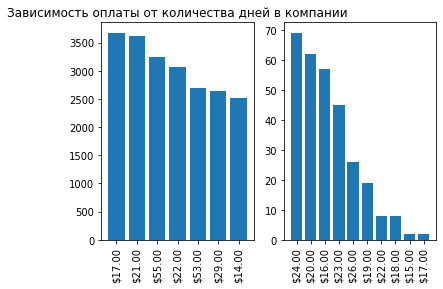

In [111]:
register_matplotlib_converters()

x1 = df4['Days Employed'].values[:10]
y1 = df4['Pay'].values[:10]

x2 = df4['Days Employed'].values[10:]
y2 = df4['Pay'].values[10:]
fig = plt.figure()

subplot1 = fig.add_subplot(121)
subplot1.bar(y1, x1)
subplot1.set_title('Зависимость оплаты от количества дней в компании')
plt.xticks(rotation='vertical')

subplot2 = fig.add_subplot(122)
subplot2.bar(y2, x2)

plt.xticks(rotation='vertical')

Наша гипотеза не подтвердилась, какой-то глобальной зависимости между оплатой и количеством дней в компании не наблюдается. Однако в рамках одной должности всё же можно заметить, что оплата в целом чуть больше у тех, кто проработал дольше.

### Гипотеза №5 ###
Зарплата на одной должности зависит от пола. <br>
Данный запрос делится на две части, мы выводим среднюю оплату для каждого пола, указывая при этом должность. Присутствует всего две должности, так как для других данных не было (после соединения таблиц).

In [123]:
###Зарплата мужчин и женщин на одной позиции различна###
df5 = pd.read_sql_query('''
(SELECT AVG(CAST(production_staff."Pay" as NUMERIC)), sex
FROM hr_dataset JOIN production_staff ON production_staff."Employee Name" = hr_dataset."Employee Name" 
WHERE hr_dataset.position = \'Production Technician I\' 
GROUP BY sex)

UNION ALL

(SELECT AVG(CAST(production_staff."Pay" as NUMERIC)) , sex
FROM hr_dataset JOIN production_staff ON production_staff."Employee Name" = hr_dataset."Employee Name" 
WHERE hr_dataset.position = \'Production Technician II\' 
GROUP BY sex)
;''', conn)
df5


,avg,sex
0,19.131928,Female
1,19.061509,Male
2,25.378108,Female
3,25.381579,Male


([0, 1], <a list of 2 Text xticklabel objects>)

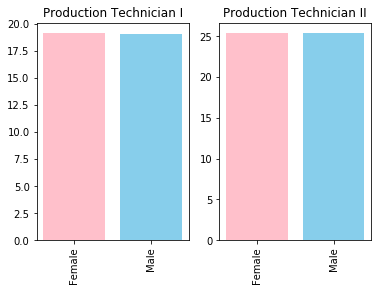

In [130]:
register_matplotlib_converters()

x1 = df5['sex'].values[:2]
y1 = df5['avg'].values[:2]

x2 = df5['sex'].values[2:]
y2 = df5['avg'].values[2:]

clr = ['pink', 'skyblue']
fig = plt.figure()

subplot1 = fig.add_subplot(121)
subplot1.bar(x1, y1, color = clr)
subplot1.set_title('Production Technician I')
plt.xticks(rotation='vertical')

subplot2 = fig.add_subplot(122)
subplot2.bar(x2, y2, color = clr)
subplot2.set_title('Production Technician II')
plt.xticks(rotation='vertical')

Наша гипотеза не подтвердилась. Женщинам и мужчинам в рамках одной должности платят одинаково и это радует :)

In [117]:
#hr_dataset

In [118]:
#production_staff


In [119]:
#recruting_costs

In [120]:
#salary_grid


## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

In [38]:
import requests

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [42]:
# получаем последние 100 записей из паблика Skillbox Вконтакте
url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&count=100&v=5.92'
response2 = getjson(url)

print(response2)

{'response': {'count': 7456, 'items': [{'id': 48213, 'from_id': -66669811, 'owner_id': -66669811, 'date': 1578326429, 'marked_as_ads': 0, 'post_type': 'post', 'text': 'Ждете, когда работа сама найдет вас? Сделайте первый шаг! Собрали для вас Telegram-каналы, публикующие новости о крутых вакансиях. Также в статье вы найдете несколько советов, которые помогут добиться работы мечты. \n\n#Статья_Skillbox #Skillbox_дизайн', 'attachments': [{'type': 'link', 'link': {'url': 'https://skillbox.ru/media/design/23_telegram_kanala_dlya_tekh_kto_ishchet_rabotu/?utm_source=skillbox.media&utm_medium=vk&utm_campaign=freelancer&utm_content=digest&utm_term=23telegramchannelsforfreelancers', 'title': '23 Telegram-канала для тех, кто ищет работу', 'caption': 'skillbox.ru', 'description': 'Мы подобрали 23 Telegram-канала, которые помогут найти крутую работу удалёнщикам и не только.', 'photo': {'id': 457285759, 'album_id': -25, 'owner_id': 2000036085, 'sizes': [{'type': 'k', 'url': 'https://sun1-93.userapi.

In [55]:
# сдвигаем запрос на 100 и получаем еще 100 записей из паблика Skillbox Вконтакте
url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=100&count=100&v=5.92'
response3 = getjson(url)

print(response3)

{'response': {'count': 7456, 'items': [{'id': 40574, 'from_id': -66669811, 'owner_id': -66669811, 'date': 1573663633, 'marked_as_ads': 0, 'post_type': 'post', 'text': 'Гоняли в детстве в Need for Speed или Asphalt? Мы — да. Но играть в собственные гонки вдвойне приятнее! Сегодня рассказываем, как за 10 шагов собрать простую гоночную игру на Unity.\n\n#Skillbox_программирование #Статья_Skillbox', 'attachments': [{'type': 'link', 'link': {'url': 'https://skillbox.ru/media/code/sozdayem_prostuyu_3d_gonku_na_unity/?utm_source=skillbox.media&utm_medium=vk&utm_campaign=profession-gamedev&utm_content=tutorial&utm_term=simplegameunity', 'title': 'Создаём простую 3D-гонку на Unity', 'caption': 'skillbox.ru', 'description': 'Гонки — один из самых популярных и простых в реализации игровых жанров. Рассказываем, как за один день создать простую 3D-гонку на Unity.', 'photo': {'id': 457285647, 'album_id': -27, 'owner_id': 2000008525, 'sizes': [{'type': 'k', 'url': 'https://sun9-28.userapi.com/c855320

In [56]:
import pandas as pd
# преобразуем наш первый json в датафрейм, указывая ?уровень вложенности?
df2 = pd.io.json.json_normalize(response2['response']['items'])

In [57]:
# преобразуем наш второй json в датафрейм
df3 = pd.io.json.json_normalize(response3['response']['items'])

In [58]:
#объединяем датафреймы
frames = [df2, df3]

result = pd.concat(frames,  ignore_index=True)

In [59]:
#выбираем интересующие нас столбцы
df_res = result[['text', 'date','likes.count','reposts.count','comments.count','views.count', 'attachments']]

In [60]:
#создадим функции для работы с датой, временем и часами отдельно
from datetime import datetime, timedelta
def only_date(date):
    return (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%Y-%m-%d')
def only_time(date):
    return (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%H:%M:%S')
def only_hour(date):
    return (datetime.fromtimestamp(date) - timedelta(hours=0)).strftime('%H')
# применям наш метод и меняем столбец с датой
df_res['dates'] = df_res['date'].apply(only_date)
df_res['time'] = df_res['date'].apply(only_time)
df_res['hour'] = df_res['date'].apply(only_hour)

C:\Users\777\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\777\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\777\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [61]:
#сохраняем наш датафрейм, чтобы уже не использовать токен
df_res.to_csv("df_res.csv")
df_res


,text,date,likes.count,reposts.count,comments.count,views.count,attachments,dates,time,hour
0,"Ждете, когда работа сама найдет вас? Сделайте ...",1578326429,70,13,0,10791,"[{'type': 'link', 'link': {'url': 'https://ski...",2020-01-06,19:00:29,19
1,"Удивляетесь, когда слышите про выученные наизу...",1578307369,234,46,0,36142,"[{'type': 'photo', 'photo': {'id': 457494606, ...",2020-01-06,13:42:49,13
2,"Новый год встречен, подарки розданы, салаты съ...",1578126642,84,3,2,32261,"[{'type': 'photo', 'photo': {'id': 457494589, ...",2020-01-04,11:30:42,11
3,"Свитер для кружки, снежколеп, носки с символик...",1577958013,27,0,55,18244,"[{'type': 'photo', 'photo': {'id': 457494572, ...",2020-01-02,12:40:13,12
4,"Зачем учиться на своих ошибках, когда можно на...",1577723417,81,14,4,16461,"[{'type': 'link', 'link': {'url': 'https://ski...",2019-12-30,19:30:17,19
5,"Кажется, что главный тренд 2019 года — статьи ...",1577710246,53,7,6,14813,"[{'type': 'link', 'link': {'url': 'https://202...",2019-12-30,15:50:46,15
6,В новый год — с новым амплуа!\n\nПодготовили д...,1577692847,118,13,167,32315,"[{'type': 'photo', 'photo': {'id': 457494564, ...",2019-12-30,11:00:47,11
7,Представьте ситуацию: долгое время вы лайкаете...,1577610139,52,4,14,31282,"[{'type': 'photo', 'photo': {'id': 457494559, ...",2019-12-29,12:02:19,12
8,Дизайнерам для вдохновения. Собрали пять iOS-и...,1577523738,122,6,2,26406,"[{'type': 'photo', 'photo': {'id': 457494553, ...",2019-12-28,12:02:18,12
9,С чем у вас ассоциируется Новый год? Мандарины...,1577440099,43,7,10,13263,"[{'type': 'photo', 'photo': {'id': 457494552, ...",2019-12-27,12:48:19,12


In [79]:
#читаем наш csv-файл
import pandas as pd
dt1 = pd.read_csv("df_res.csv")


## 1. Среднее число лайков, репостов, комментариев и просмотров по часам
Мною взяты данные в период с *27.01.2019 по 06.01.2020*. <br>
Для того, чтобы посчитать среднее число всех интересующих нас показателей по часам, я создала дополнительный столбец, в котором фиксировался только час публикации. Таким образом мы группируем наши данные по часам и считаем среднее. <br>
Далее мы строим графики.

In [80]:
dt2 = dt1.groupby('hour').agg('mean')

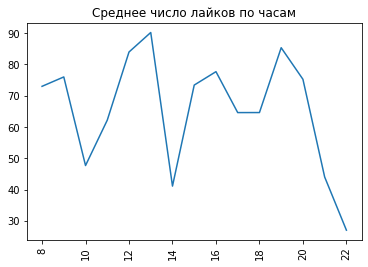

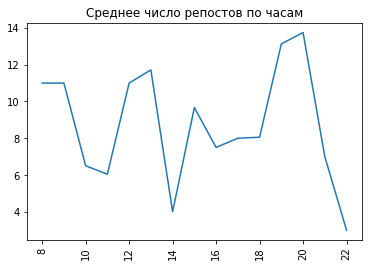

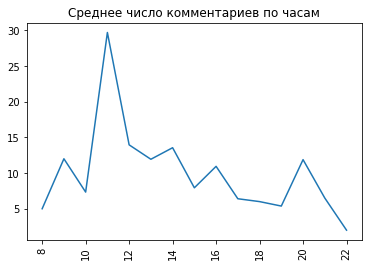

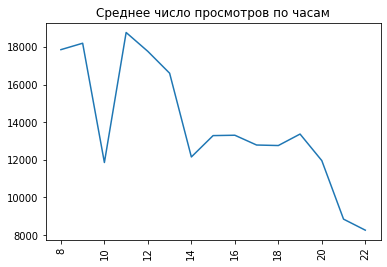

In [81]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

register_matplotlib_converters()

fig, subplot = plt.subplots()

x_values = dt2.index
y_values = dt2['likes.count'].values
subplot.plot(
    x_values, y_values
)
plt.xticks(rotation='vertical')
subplot.set_title('Среднее число лайков по часам')


fig, subplot = plt.subplots()

x_values = dt2.index
y_values = dt2['reposts.count'].values
subplot.plot(
    x_values, y_values
)
plt.xticks(rotation='vertical')
subplot.set_title('Среднее число репостов по часам')

fig, subplot = plt.subplots()

x_values = dt2.index
y_values = dt2['comments.count'].values
subplot.plot(
    x_values, y_values
)
plt.xticks(rotation='vertical')
subplot.set_title('Среднее число комментариев по часам')

fig, subplot = plt.subplots()

x_values = dt2.index
y_values = dt2['views.count'].values
subplot.plot(
    x_values, y_values
)
plt.xticks(rotation='vertical')
subplot.set_title('Среднее число просмотров по часам')

plt.show()

## Вывод 1
Исходя из полученных графиков мы можем сделать однозначный вывод, что самое эффективное время приходится на **12 часов дня**. Так как у SkillBox аудитория преимущественно взрослая, скорее всего люди просматривают посты, а так же проявляют какую-то активность в **обеденное время**. <br>
Следующий пик приходится примерно на **8 часов вечера**, а именно когда участники сообщества возвращаются домой и могут провести время в социальных сетях. <br>
Таким образом, посты выложенные в эти часы будут иметь самые высокие показатели по активности, поэтому есть смысл публиковать наиболее *важную информацию* в это время, если нужно сообщить нечто важное, либо публиковать что-то *интересное*, чтобы привлечь людей.

## 2. Медианное число лайков, репостов, комментариев и просмотров по выбранным тэгам
**2.1** В этом пункте я выбрала рубрики, содержащие в себе интерактив *(Дизайн-битва, Игра, Задачка и Кейс)*, а в противовес взяла самую рядовую рубрику - *Статью*. <br>
**2.2** Так же я сравнила публикации по тэгам направления *(маркетинг, управление, дизайн, маркетинг)* <br>
Сначала, с поомощью регулярных выражений и свойств множества выведем тэги. А затем отфильтруем строки и построим графики. 

In [82]:
import re
tag_set=set()
for n in range(0,200,1):
    raw_text = dt1.text.values[n]

    reg_expr = r'#\w+\b'

    reg_expr_compiled = re.compile(reg_expr)

    for g in reg_expr_compiled.findall(raw_text):
        tag_set.add(g)
tag_set

{'#191970',
 '#7FFFD4',
 '#Cоветпрепода_Skillbox',
 '#Design_Battle_Skillbox',
 '#Design_battle',
 '#FF4500',
 '#MailDesignCup',
 '#OFFF_Moscow',
 '#Skillbox_OFFF',
 '#Skillbox_Pinkman',
 '#Skillbox_Sreda',
 '#Skillbox_Дизайн',
 '#Skillbox_Маркетинг',
 '#Skillbox_Симпсоны',
 '#Skillbox_Сострадамус',
 '#Skillbox_акция',
 '#Skillbox_в_закладки',
 '#Skillbox_вдохновляет',
 '#Skillbox_взакладки',
 '#Skillbox_вопросы',
 '#Skillbox_дизайн',
 '#Skillbox_игра',
 '#Skillbox_кейс',
 '#Skillbox_конкурс',
 '#Skillbox_маркетинг',
 '#Skillbox_образование',
 '#Skillbox_программирование',
 '#Skillbox_управление',
 '#Skillboxвдохновляет',
 '#Skillboxдизайн',
 '#Skillboxподкаст',
 '#Skillbохдизайн',
 '#Skillbохмаркетинг',
 '#skillbox_sreda',
 '#skillbox_тренды',
 '#Анонс_Skillbox',
 '#В_закладки_Skillbox',
 '#Вам_слово',
 '#Вам_слово_Skillbox',
 '#Вебинар_Skillbox',
 '#Взакладки',
 '#Взакладки_Skillbox',
 '#ДеньКомпьютернойГрафики',
 '#Задачка_Skillbox',
 '#Защита_дипломов_Skillbox',
 '#Игра_Skillbox',


In [84]:
# здесь мы проверяем содержаться ли интересующие нас тэги в тексте, отобранные строки сохранаяются в новый датасет, затем он транспонируется

battle_dt = dt1[dt1['text'].str.contains('#Design_Battle_Skillbox') | dt1['text'].str.contains('#Design_battle')]
battle_median = pd.DataFrame(battle_dt.median()).T

game_dt = dt1[dt1['text'].str.contains('#Игра_Skillbox') | dt1['text'].str.contains('#Skillbox_игра')]
game_median = pd.DataFrame(game_dt.median()).T

task_dt = dt1[dt1['text'].str.contains('#Задачка_Skillbox')]
task_median = pd.DataFrame(task_dt.median()).T

case_dt = dt1[dt1['text'].str.contains('#Кейс_Skillbox') 
    | dt1['text'].str.contains('#Skillbox_кейс')
    | dt1['text'].str.contains('#кейсSkillbox')]
case_median = pd.DataFrame(case_dt.median()).T

article_dt = dt1[dt1['text'].str.contains('#Статья_Skillbox') | dt1['text'].str.contains('#статья_Skillbox')]
article_median = pd.DataFrame(article_dt.median()).T



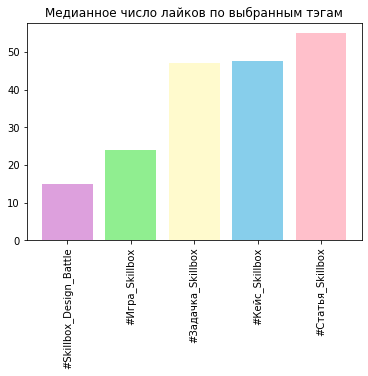

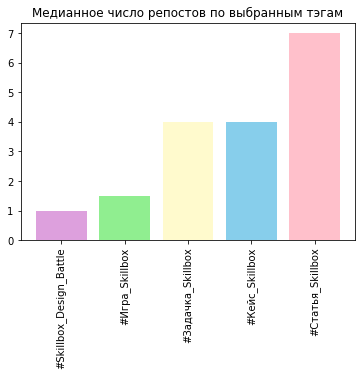

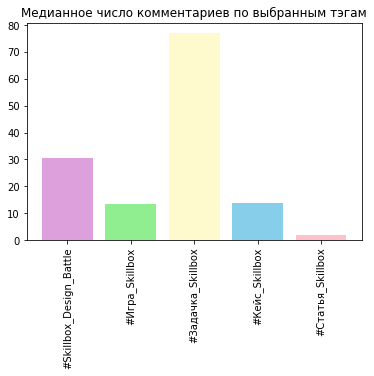

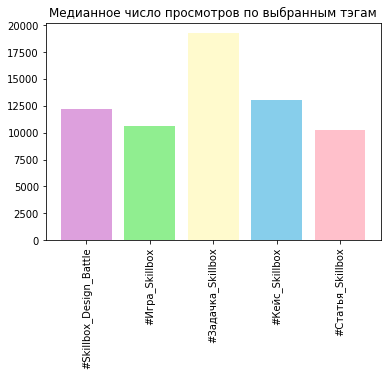

In [93]:
# строим графики
x_values = ['#Skillbox_Design_Battle','#Игра_Skillbox','#Задачка_Skillbox','#Кейс_Skillbox', '#Статья_Skillbox']
y_values = [battle_median.loc[0, 'likes.count'], game_median.loc[0, 'likes.count'], 
            task_median.loc[0, 'likes.count'], case_median.loc[0, 'likes.count'], 
            article_median.loc[0, 'likes.count']]
clr = ('plum', 'lightgreen', 'lemonchiffon', 'skyblue', 'pink')
fig, subplot = plt.subplots()
subplot.bar(x_values, y_values, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число лайков по выбранным тэгам')


y_values = [battle_median.loc[0, 'reposts.count'], game_median.loc[0, 'reposts.count'], 
            task_median.loc[0, 'reposts.count'], case_median.loc[0, 'reposts.count'], 
            article_median.loc[0, 'reposts.count']]

fig, subplot = plt.subplots()
subplot.bar(x_values, y_values, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число репостов по выбранным тэгам')


y_values = [battle_median.loc[0, 'comments.count'], game_median.loc[0, 'comments.count'], 
            task_median.loc[0, 'comments.count'], case_median.loc[0, 'comments.count'], 
            article_median.loc[0, 'comments.count']]

fig, subplot = plt.subplots()
subplot.bar(x_values, y_values, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число комментариев по выбранным тэгам')


y_values = [battle_median.loc[0, 'views.count'], game_median.loc[0, 'views.count'], 
            task_median.loc[0, 'views.count'], case_median.loc[0, 'views.count'], 
            article_median.loc[0, 'views.count']]

fig, subplot = plt.subplots()
subplot.bar(x_values, y_values, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число просмотров по выбранным тэгам')

plt.show()

### Вывод 2.1
Исходя из графиков можно сделать вывод, что самыми популярными, в плане лайков и репостов, интерактивными рубриками являются **Задачки** и **Кейсы**. Рубрика **Статья** по этим показетелям обгоняет все интерктивные рубрики. <br>
Однако уже на графике с комментариями мы видим, что с большим отрывом на первом месте находятся **Задачки**. Это значит, что наибольшую активность у участников сообщества вызывает *интеллектуальная деятельность*, а именно решение задач.

In [92]:
#так же фильтруем нужные строки
business_dt = dt1[dt1['text'].str.contains('#Skillbox_управление') ]
business_median = pd.DataFrame(business_dt.median()).T

marketing_dt = dt1[dt1['text'].str.contains('#Skillbox_Маркетинг') | dt1['text'].str.contains('#Skillbox_маркетинг')
                  | dt1['text'].str.contains('#Skillboxмаркетинг')]
marketing_median = pd.DataFrame(marketing_dt.median()).T

design_dt = dt1[dt1['text'].str.contains('#Skillbox_Дизайн') | dt1['text'].str.contains('#Skillbox_дизайн')
               | dt1['text'].str.contains('#Skillboxдизайн')| dt1['text'].str.contains('#Skillbохдизайн')]
design_median = pd.DataFrame(design_dt.median()).T

prog_dt = dt1[dt1['text'].str.contains('#Skillbox_программирование') 
    | dt1['text'].str.contains('#Программирование_Skillbox')]
prog_median = pd.DataFrame(prog_dt.median()).T

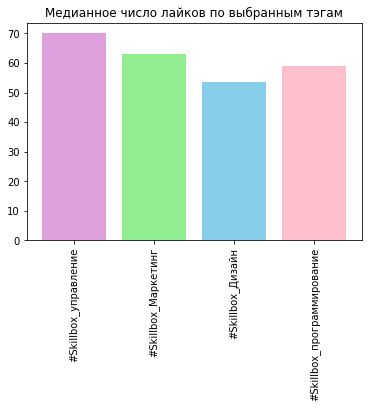

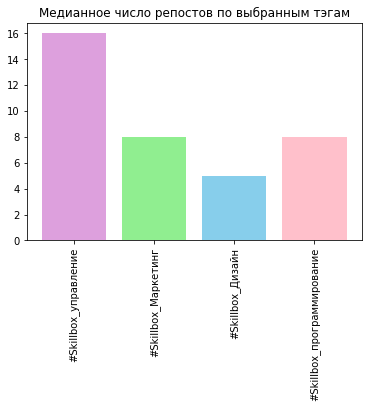

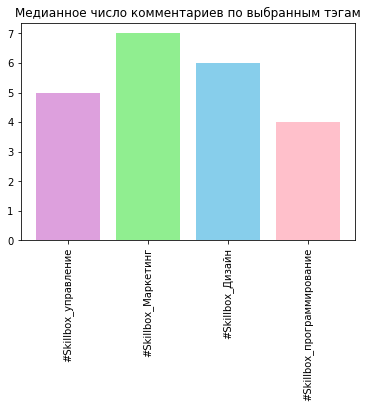

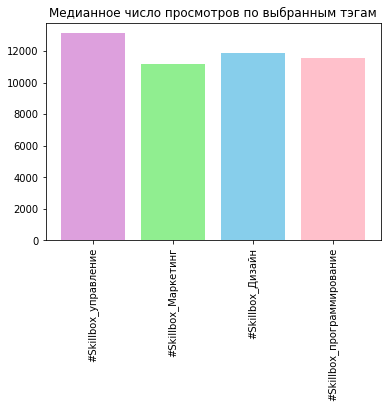

In [95]:
# строим графики
x_values = ['#Skillbox_управление','#Skillbox_Маркетинг','#Skillbox_Дизайн','#Skillbox_программирование']
y_values = [business_median.loc[0, 'likes.count'], marketing_median.loc[0, 'likes.count'], 
            design_median.loc[0, 'likes.count'], prog_median.loc[0, 'likes.count']]
clr = ('plum', 'lightgreen', 'skyblue', 'pink')
fig, subplot = plt.subplots()
subplot.bar(x_values, y_values, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число лайков по выбранным тэгам')


y_values = [business_median.loc[0, 'reposts.count'], marketing_median.loc[0, 'reposts.count'], 
            design_median.loc[0, 'reposts.count'], prog_median.loc[0, 'reposts.count']]

fig, subplot = plt.subplots()
subplot.bar(x_values, y_values, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число репостов по выбранным тэгам')


y_values = [business_median.loc[0, 'comments.count'], marketing_median.loc[0, 'comments.count'], 
            design_median.loc[0, 'comments.count'], prog_median.loc[0, 'comments.count']]

fig, subplot = plt.subplots()
subplot.bar(x_values, y_values, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число комментариев по выбранным тэгам')


y_values = [business_median.loc[0, 'views.count'], marketing_median.loc[0, 'views.count'], 
            design_median.loc[0, 'views.count'], prog_median.loc[0, 'views.count']]

fig, subplot = plt.subplots()
subplot.bar(x_values, y_values, color = clr )
plt.xticks(rotation='vertical')
subplot.set_title('Медианное число просмотров по выбранным тэгам')

plt.show()

### Вывод 2.2
Суммарно, исходя из трех графиков, можно сделать вывод о том, что направление **Управление** вызывает наибольшую активность у участниуов сообщества. В целом показатели у всех направлений примерно на одном уровне, кроме репостов по направлению **Дизайн**. Но я не думаю, что это показатель, возможно в выбранном временном промежутке было не так много постов по дизайну, либо они были менее интерсны подписчикам.

## Вывод 2
Небольшое пожелание для SMM-отдела. На мой взгляд нужно сделать единую систему тэгов, так как сейчас там меняется порядок слов или написание тэга, из-за этого человек просто не сможет получить доступ ко всем статьям по выбранному тэгу. <br>
Возможно стоит все используемые тэги вынести куда-то, в обсуждения или в описание. Это облегчит поиск информации.